## Kaggle - Introduction to Time Series Clustering

Ref - https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook

### 2. Analysis
#### 2. 1. Let's check the data

In [2]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [3]:
#directory = '/kaggle/input/retail-and-retailers-sales-time-series-collection/'
directory = '/home/pabhijit/scripts/06 - Others/misc/kaggle/data/'

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","value"]]
        
        # While we are at it I just filtered the columns that we will be working on
        df.set_index("date",inplace=True)
        
        # ,set the date columns as index
        df.sort_index(inplace=True)
        
        # and lastly, ordered the data according to our date index
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

In [4]:
print(len(mySeries))

23


In [40]:
namesofMySeries

['MRTSMPCSM4400CUSN',
 'MRTSSM44000USS',
 'MRTSSM44111USN',
 'MRTSSM44112USN',
 'MRTSSM4413USS',
 'MRTSSM442USN',
 'MRTSSM442USS',
 'MRTSSM444USS',
 'MRTSSM4453USN',
 'MRTSSM44611USN',
 'MRTSSM4481USN',
 'MRTSSM448USS',
 'MRTSSM44X72USS',
 'MRTSSM45111USN',
 'MRTSSM45112USN',
 'MRTSSM4541USS',
 'MRTSSM7221USN',
 'RETAILIMSA',
 'RETAILIRSA',
 'RETAILMPCSMNSA',
 'RETAILMPCSMSA',
 'RETAILSMNSA',
 'RETAILSMSA']

In [45]:
mySeries[0]

array([0.53953488, 0.53953488, 0.59627907, 0.54697674, 0.54139535,
       0.47627907, 0.50232558, 0.58697674, 0.4372093 , 0.58046512,
       0.6344186 , 1.        , 0.00744186, 0.4827907 , 0.64093023,
       0.55813953, 0.53953488, 0.48372093, 0.51348837, 0.55627907,
       0.45860465, 0.5544186 , 0.65116279, 0.97302326, 0.        ,
       0.5227907 , 0.69116279, 0.48651163, 0.53767442, 0.51813953,
       0.4827907 , 0.5944186 , 0.44837209, 0.55348837, 0.65674419,
       0.96651163, 0.00744186, 0.48744186, 0.67255814, 0.50232558,
       0.55627907, 0.50511628, 0.4744186 , 0.59069767, 0.45488372,
       0.51255814, 0.69674419, 0.92186047, 0.01209302, 0.55627907,
       0.61488372, 0.50232558, 0.57674419, 0.47069767, 0.48465116,
       0.61302326, 0.41395349, 0.56465116, 0.65023256, 0.91627907,
       0.03906977, 0.50046512, 0.65581395, 0.46232558, 0.59348837,
       0.46976744, 0.50418605, 0.59069767, 0.41674419, 0.57209302,
       0.6372093 , 0.91906977, 0.05302326, 0.50232558, 0.61395

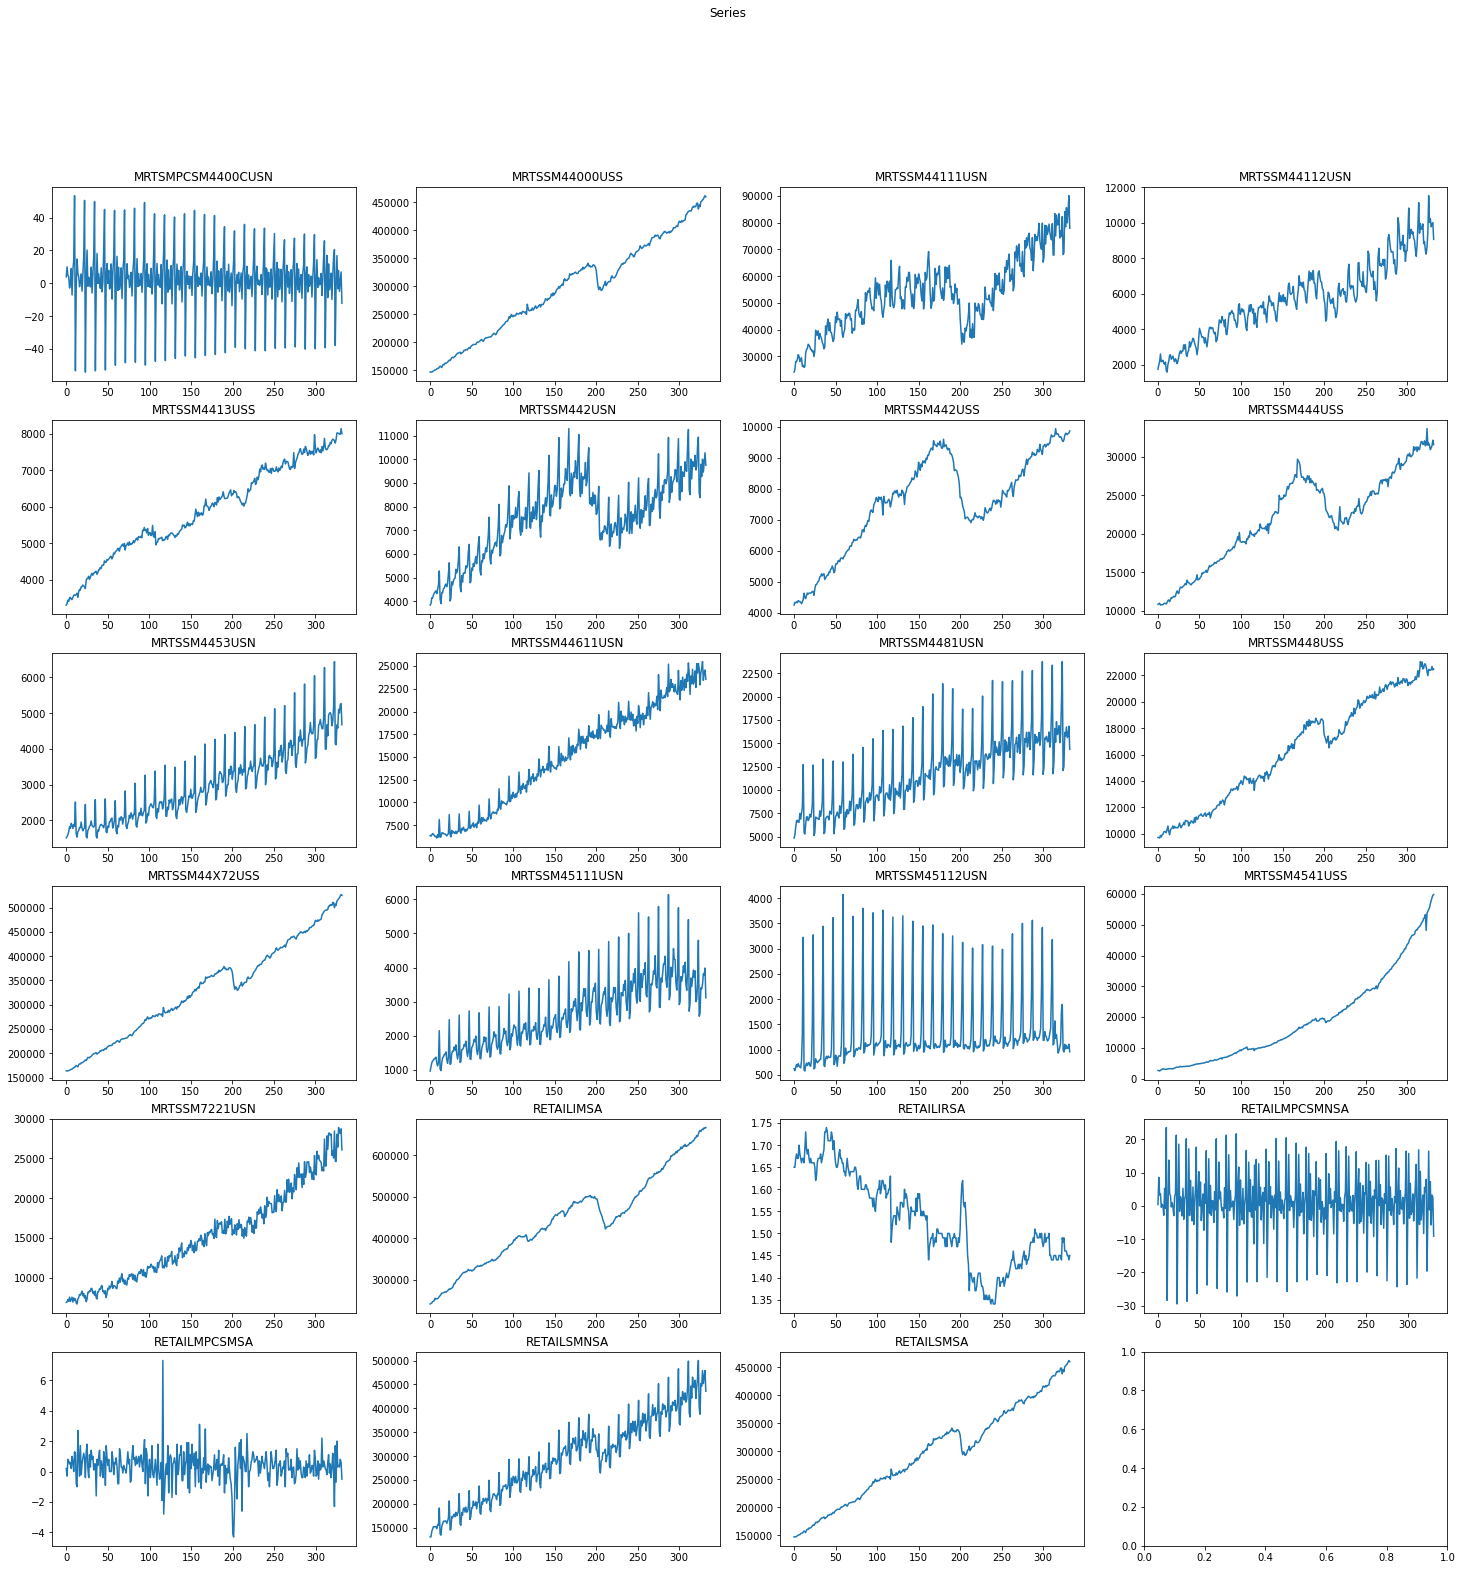

In [5]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

#### 2. 2. Preprocessing

In [6]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


In [7]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"] "+series.index[0]+" "+series.index[len(series)-1])
    ind+=1

[0] 1992-02-01 2019-09-01
[1] 1992-01-01 2019-09-01
[2] 1992-01-01 2019-09-01
[3] 1992-01-01 2019-09-01
[4] 1992-01-01 2019-09-01
[5] 1992-01-01 2019-09-01
[6] 1992-01-01 2019-09-01
[7] 1992-01-01 2019-09-01
[8] 1992-01-01 2019-09-01
[9] 1992-01-01 2019-09-01
[10] 1992-01-01 2019-09-01
[11] 1992-01-01 2019-09-01
[12] 1992-01-01 2019-09-01
[13] 1992-01-01 2019-09-01
[14] 1992-01-01 2019-09-01
[15] 1992-01-01 2019-09-01
[16] 1992-01-01 2019-09-01
[17] 1992-01-01 2019-09-01
[18] 1992-01-01 2019-09-01
[19] 1992-02-01 2019-09-01
[20] 1992-02-01 2019-09-01
[21] 1992-01-01 2019-09-01
[22] 1992-01-01 2019-09-01


In [8]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [9]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

In [10]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [11]:
nan_counter(mySeries)

3


In [12]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [13]:
nan_counter(mySeries)

0


In [14]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [15]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.53953488 0.53953488 0.59627907 0.54697674 0.54139535]


### 2. 3. Clustering
#### 2. 3. 1. SOM

In [16]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

#### 2. 3. 1. 1. Results
After the training, I plotted the results. For each cluster, I plotted every series, a little bit transparent and in gray, and in order to see the movement or the shape of the cluster, I took the average of the cluster and plotted that averaged series in red .

In [17]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

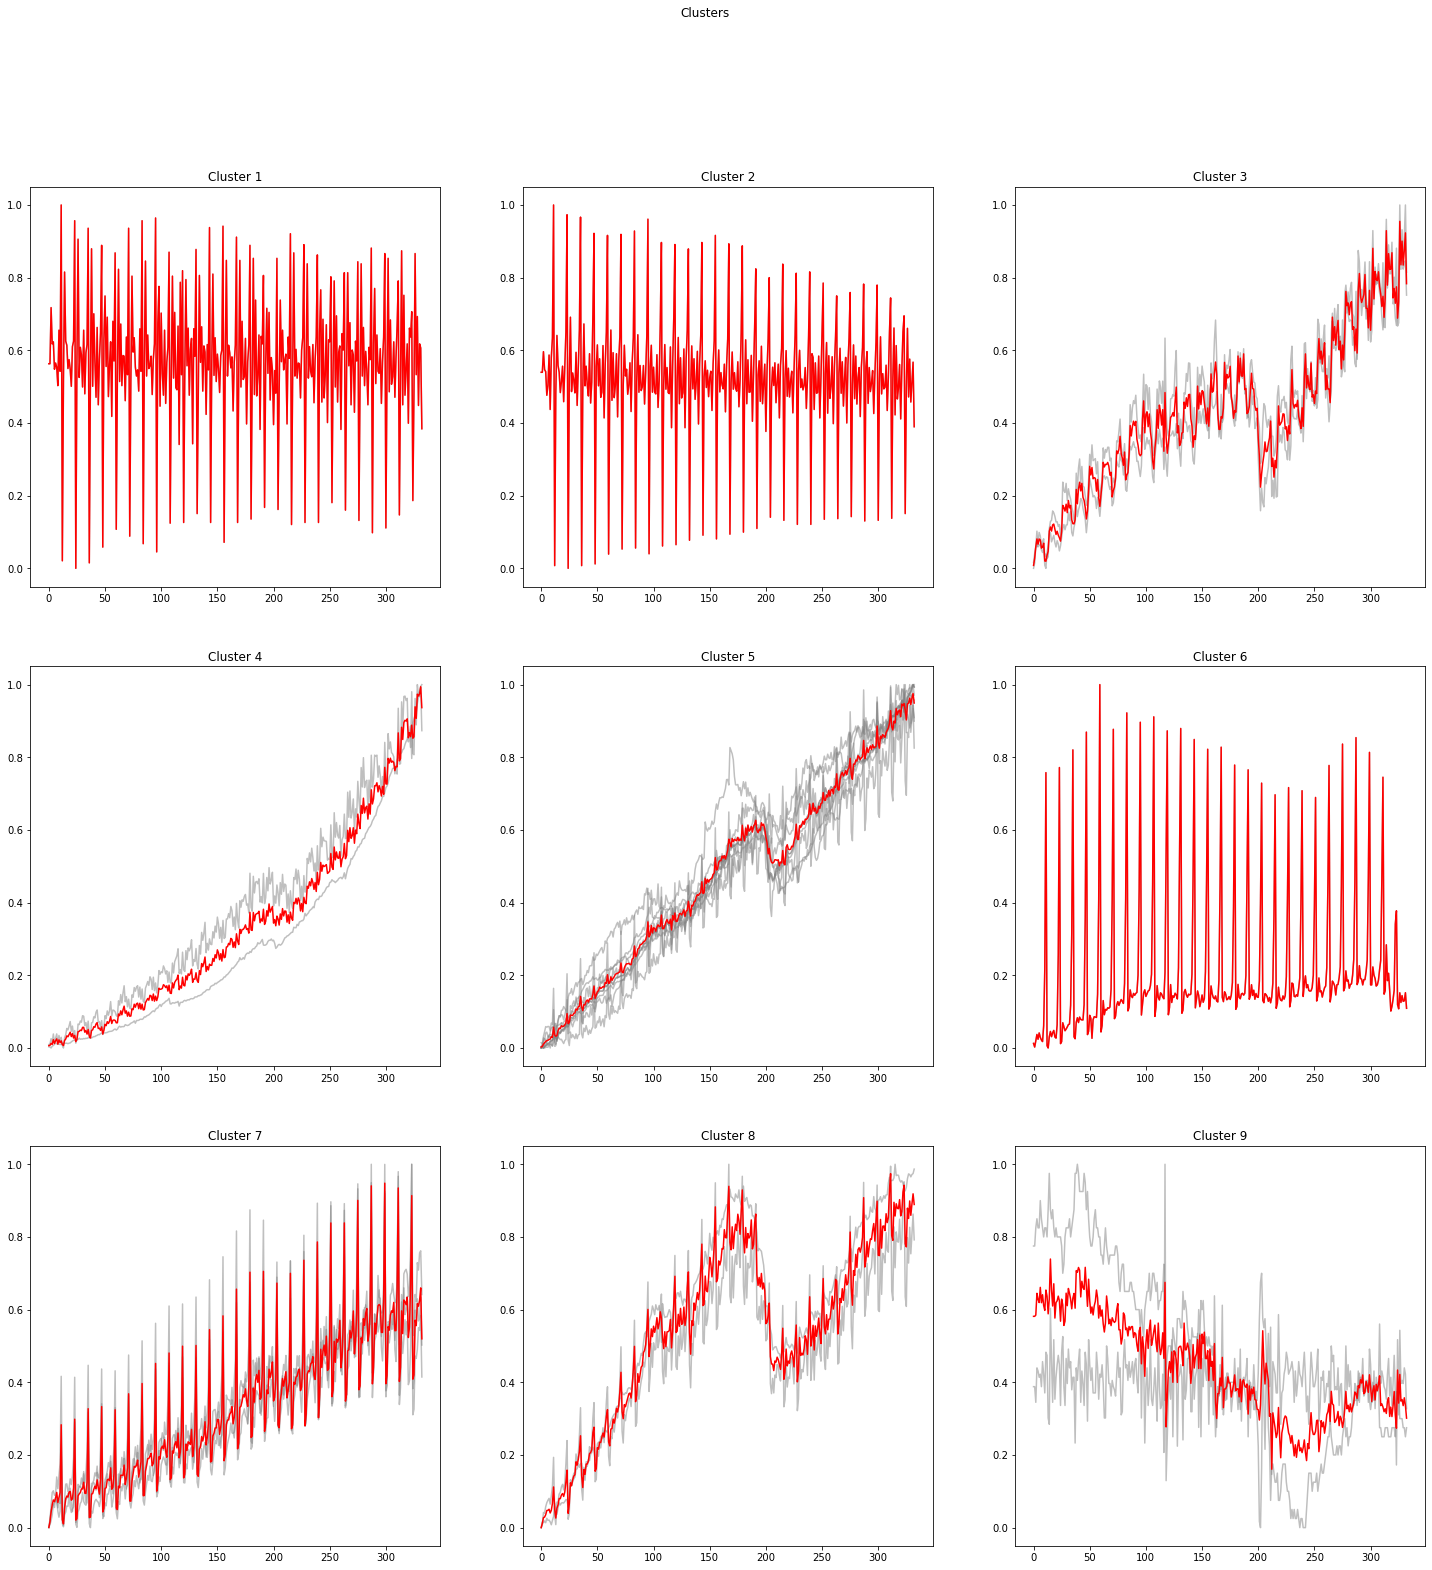

In [18]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [19]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

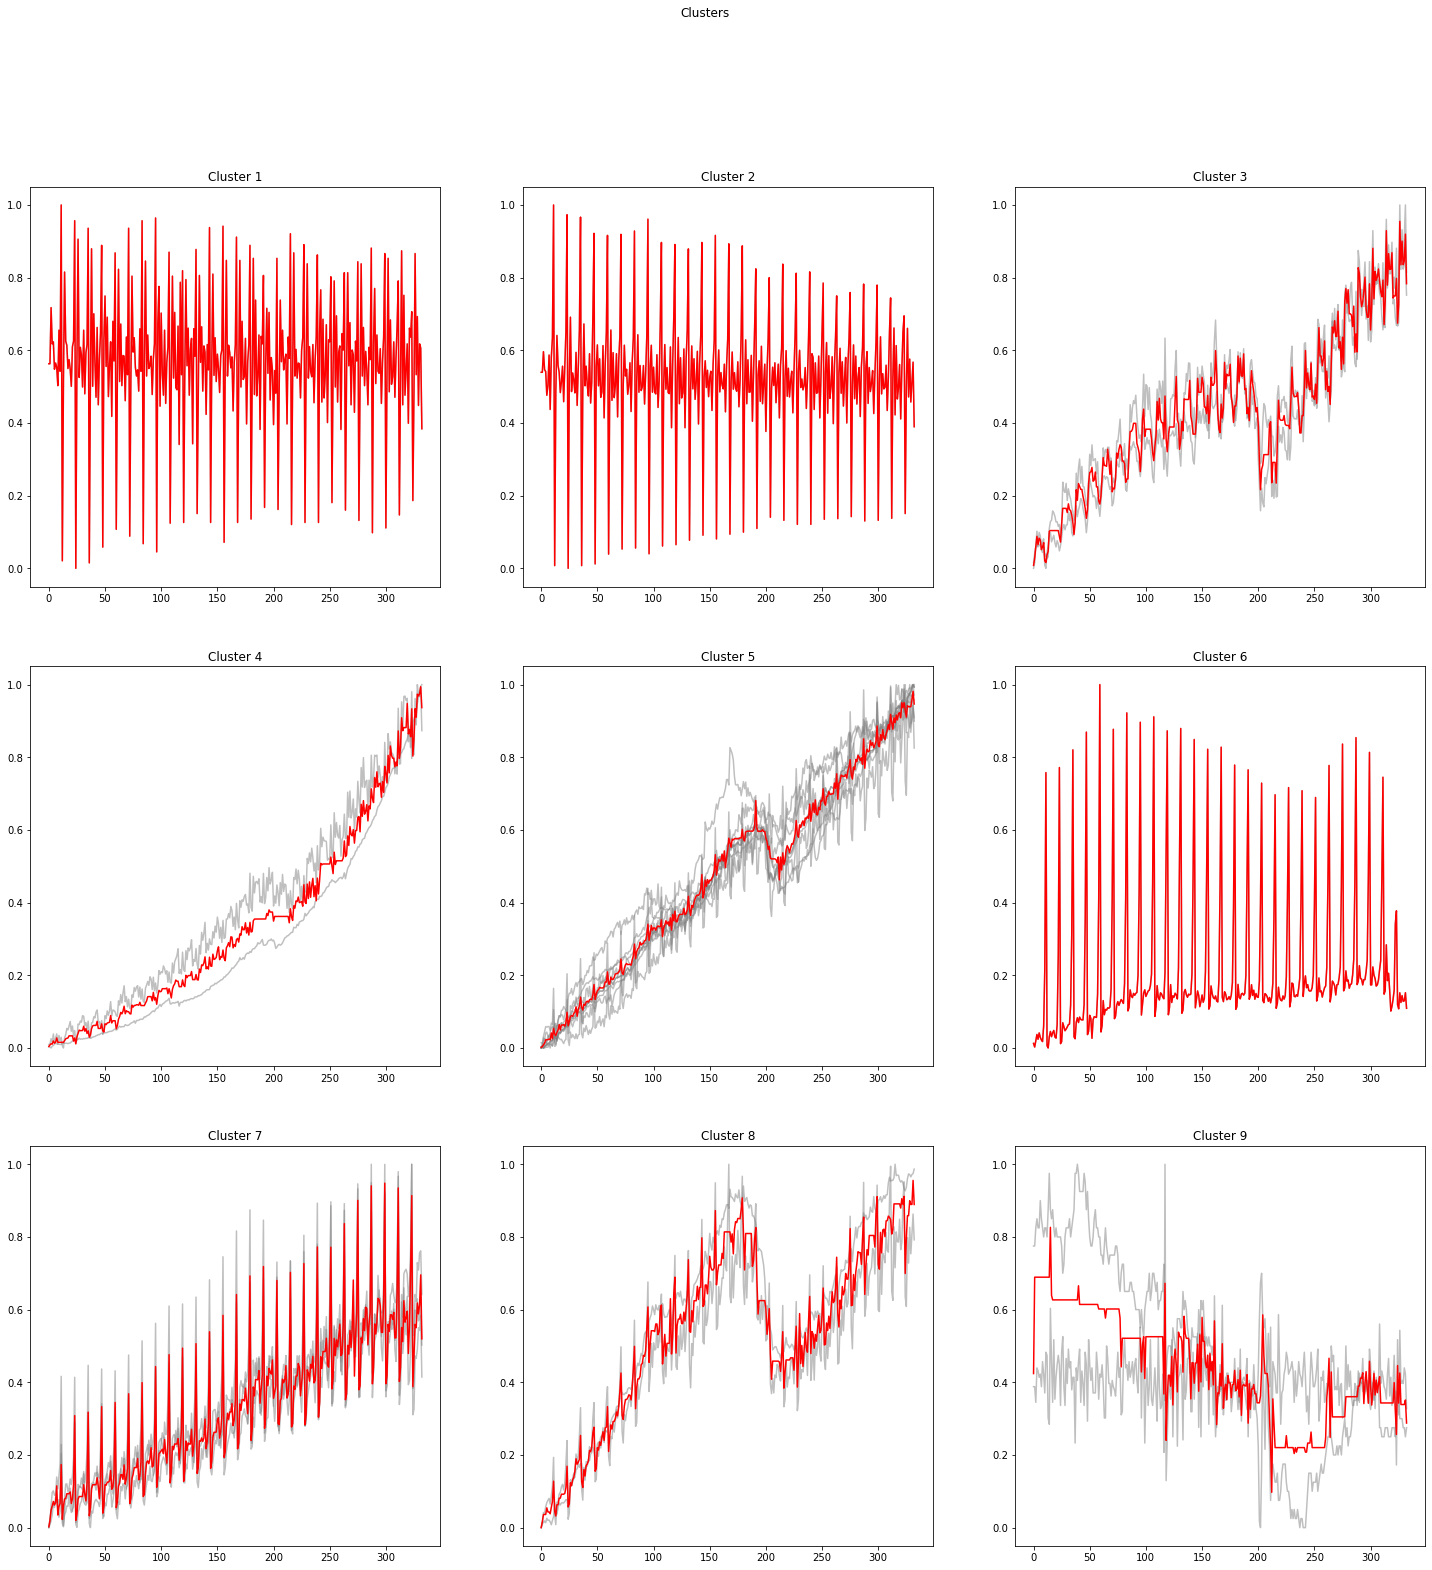

In [20]:
win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_y, win_map)

#### 2. 3. 1. 2. Cluster Distribution
We can see the distribution of the time series in clusters in the following chart.

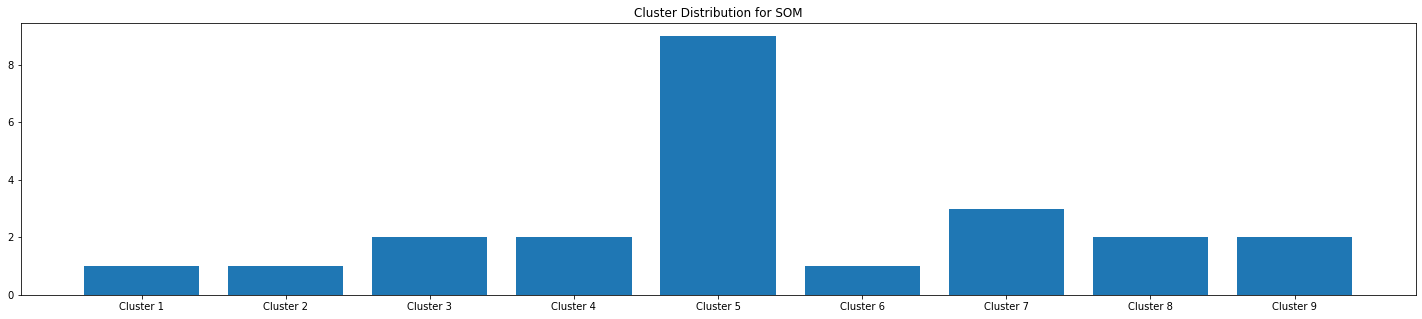

In [21]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

#### 2. 3. 1. 3. Cluster Mapping

In [22]:
# Let's check first 5
for series in mySeries[:5]:
    print(som.winner(series))

(0, 1)
(1, 1)
(0, 2)
(0, 2)
(1, 1)


In [23]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
RETAILMPCSMNSA,Cluster 1
MRTSMPCSM4400CUSN,Cluster 2
MRTSSM44111USN,Cluster 3
MRTSSM44112USN,Cluster 3
MRTSSM7221USN,Cluster 4
MRTSSM4541USS,Cluster 4
RETAILIMSA,Cluster 5
MRTSSM44X72USS,Cluster 5
RETAILSMNSA,Cluster 5


#### 2. 3. 2. K-Means

In [24]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

#### 2. 3. 2. 1. Results

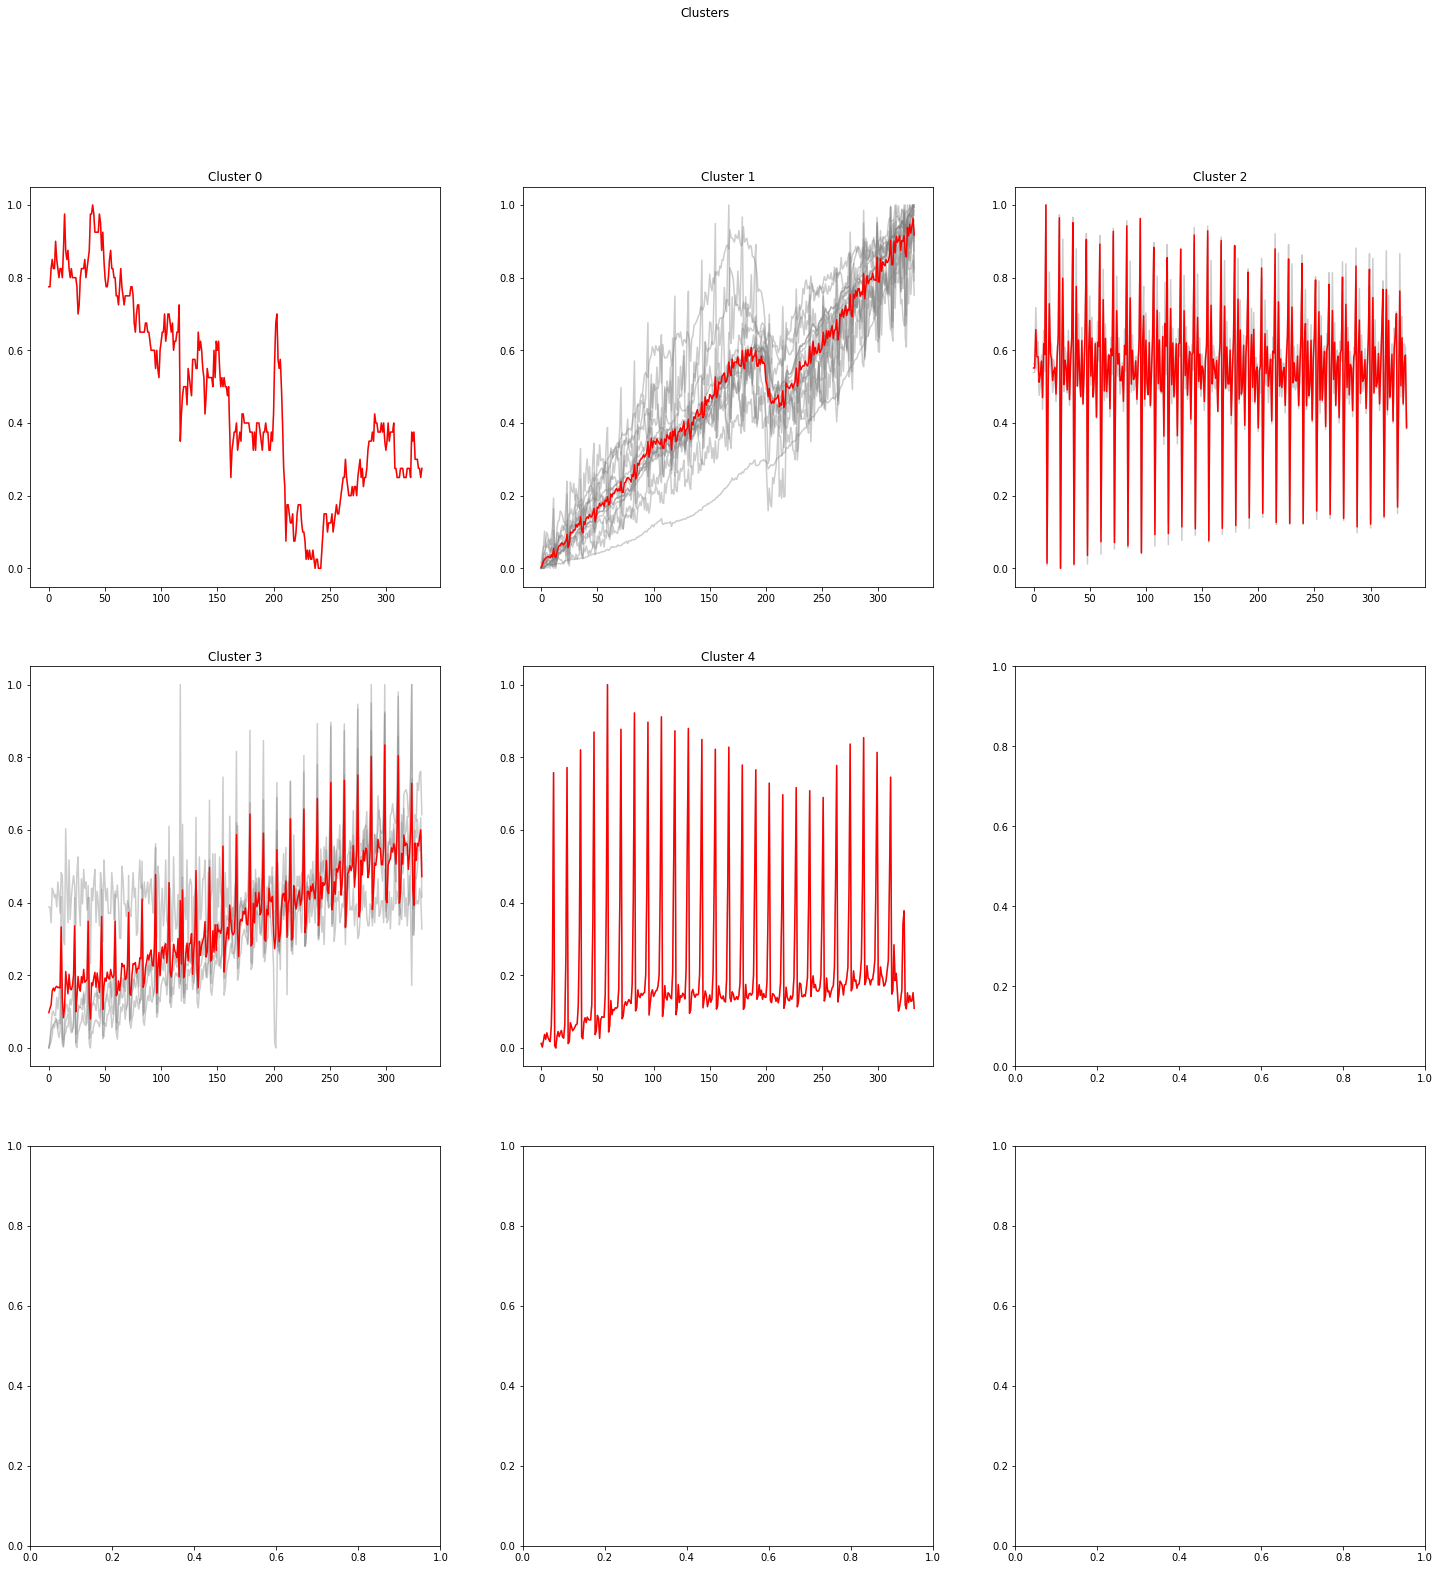

In [25]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

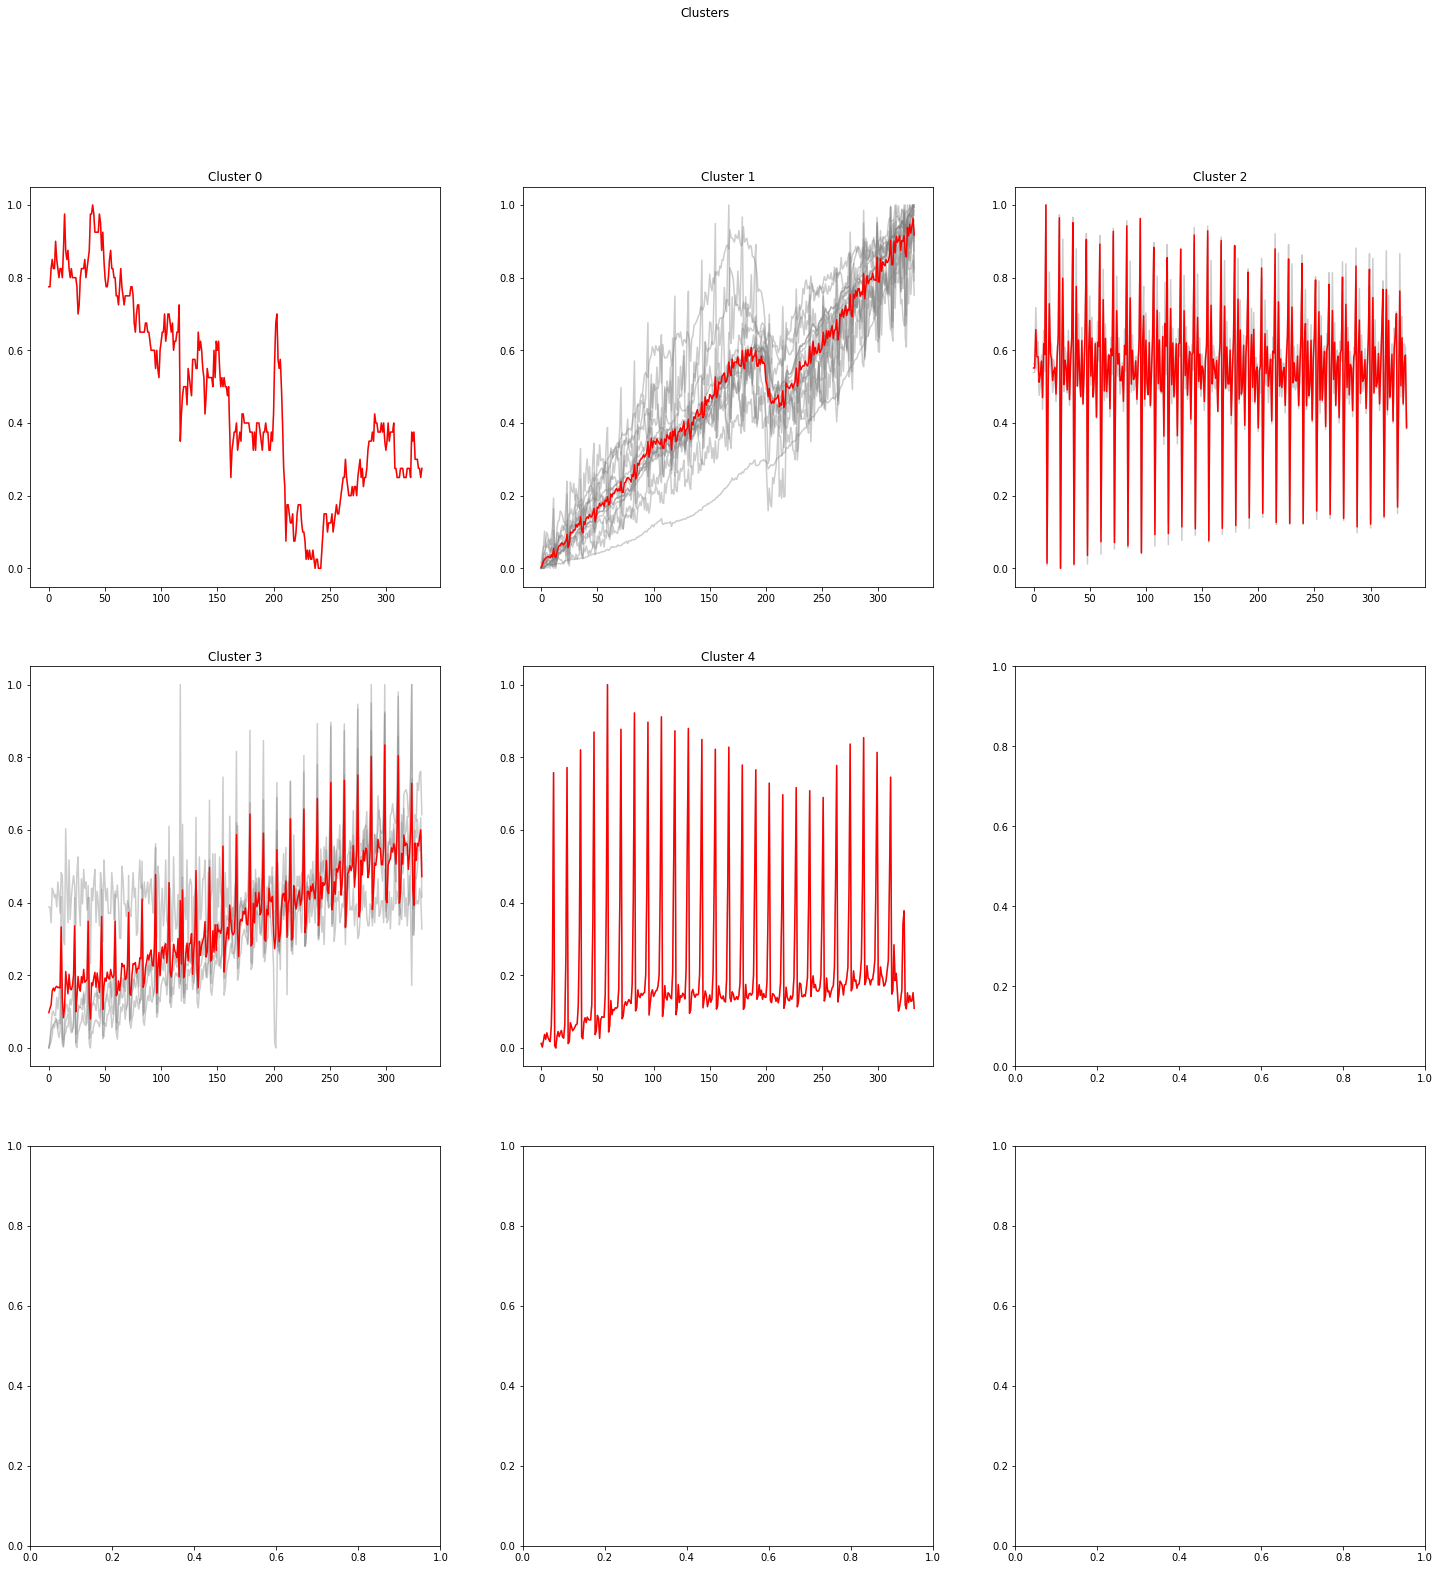

In [26]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

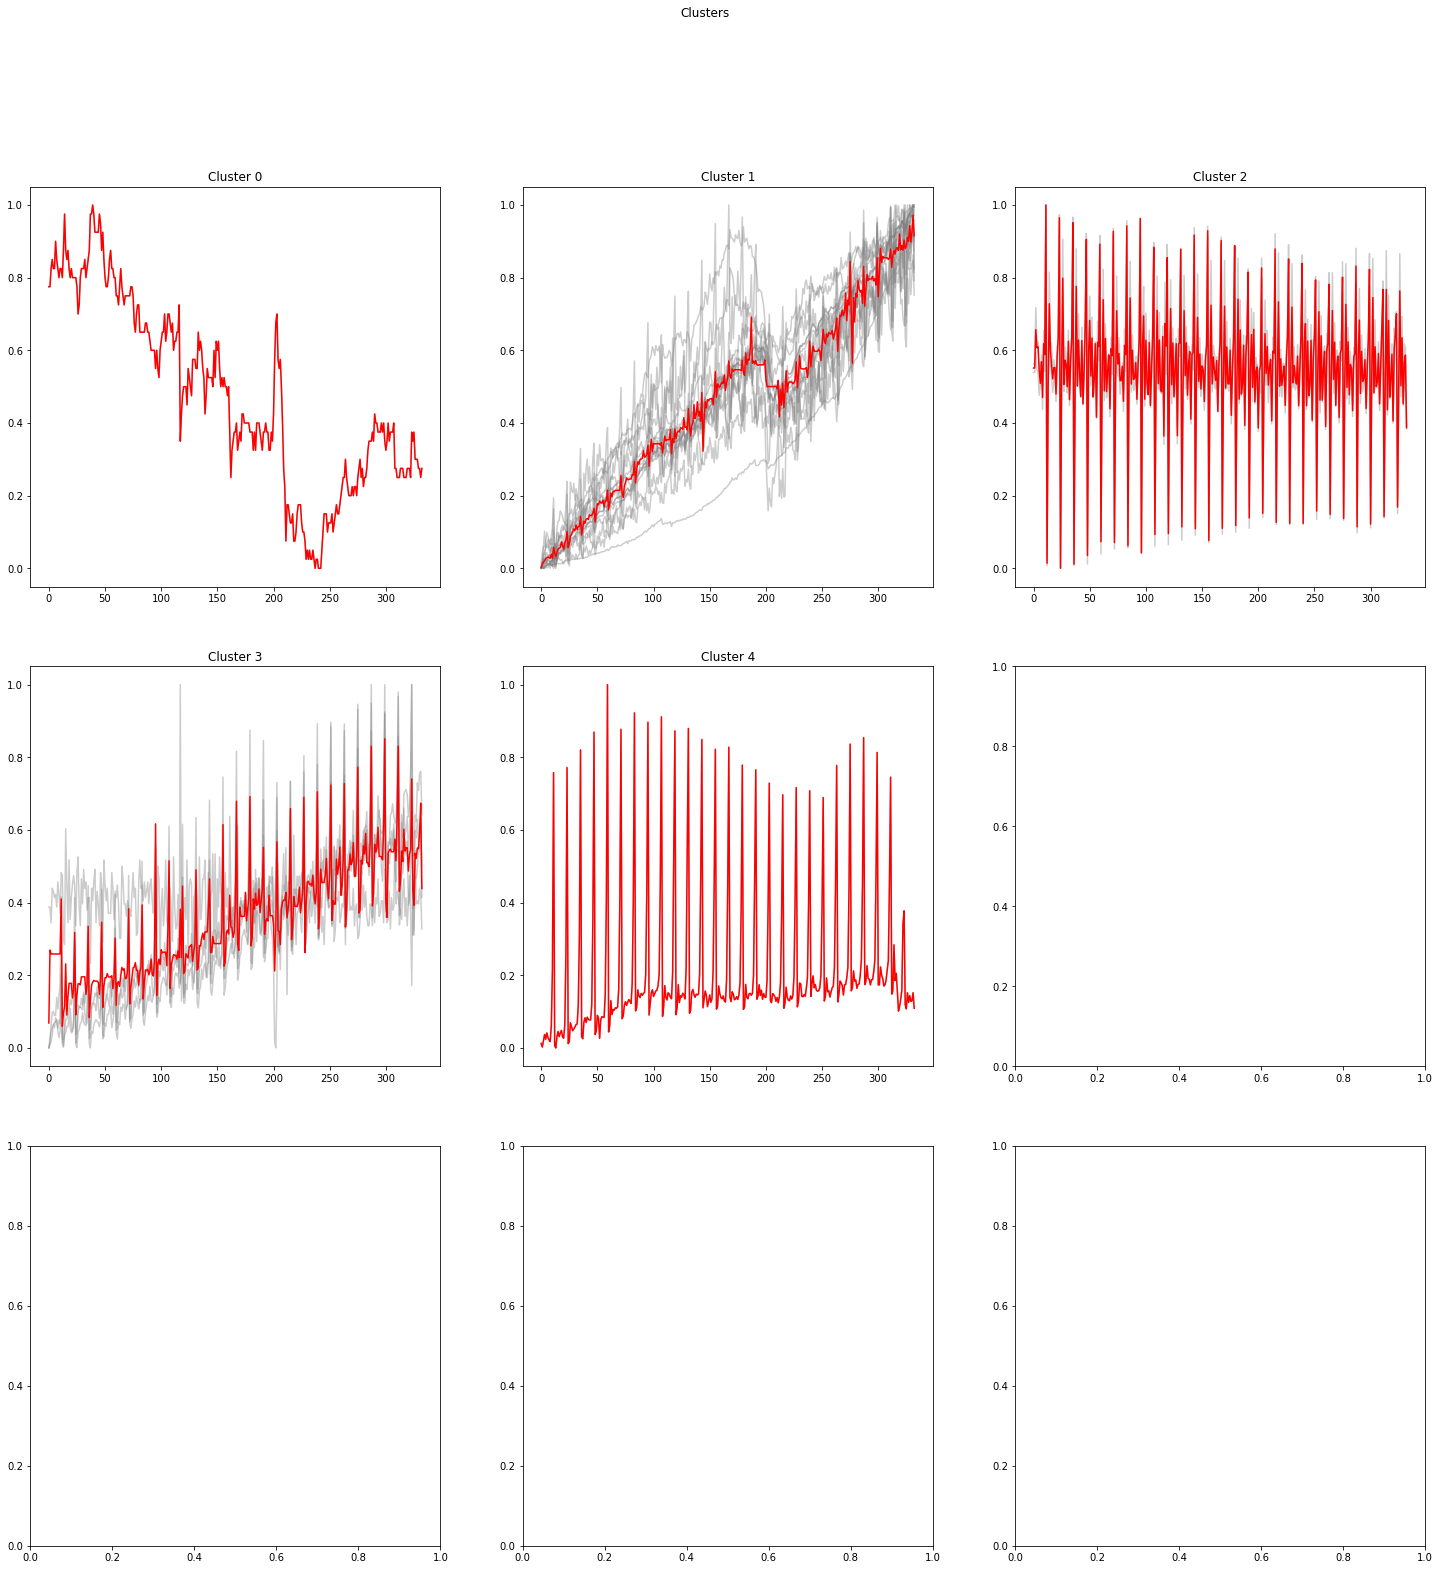

In [27]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

#### 2. 3. 2. 2. Cluster Distribution

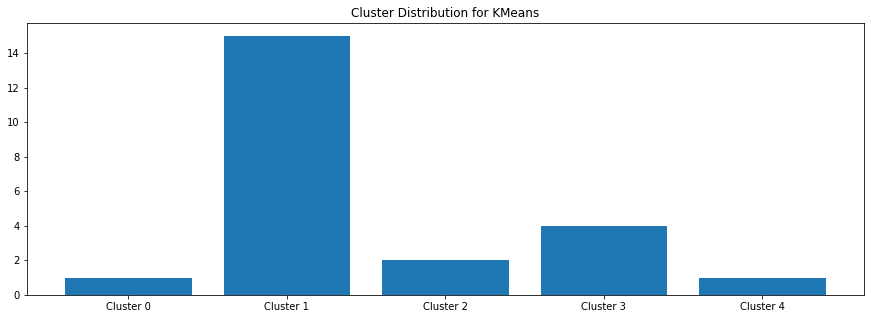

In [28]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

#### 2. 3. 2. 3. Cluster Mapping

In [29]:
labels

array([2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 4, 1, 1, 1, 0, 2, 3, 1,
       1])

In [30]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
RETAILIRSA,Cluster 0
MRTSSM448USS,Cluster 1
RETAILIMSA,Cluster 1
MRTSSM7221USN,Cluster 1
MRTSSM4541USS,Cluster 1
MRTSSM44X72USS,Cluster 1
RETAILSMNSA,Cluster 1
MRTSSM44611USN,Cluster 1
RETAILSMSA,Cluster 1


#### 2. 3. 2. 4. Curse of Dimensionality

In [31]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(mySeries)

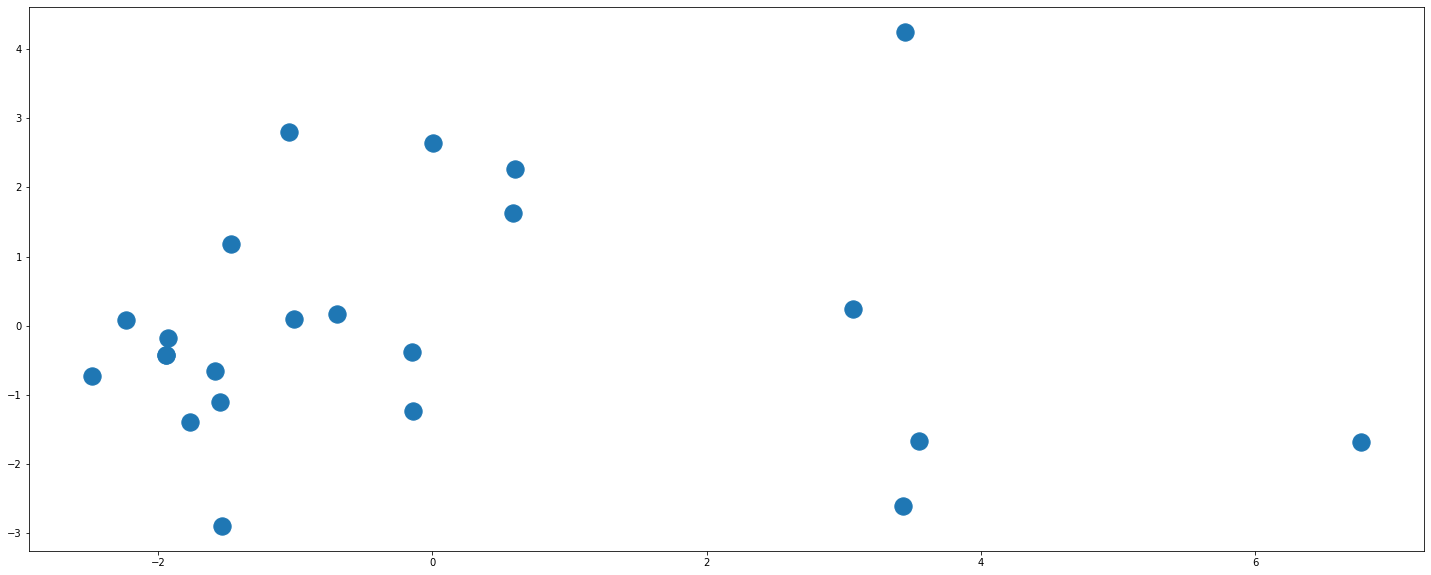

In [32]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [33]:
print(mySeries_transformed[0:5])

[[ 3.55106153 -1.66874895]
 [-1.94119833 -0.41697393]
 [-0.14827418 -0.38116355]
 [-0.69665451  0.17375693]
 [-1.76864215 -1.38385377]]


In [34]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

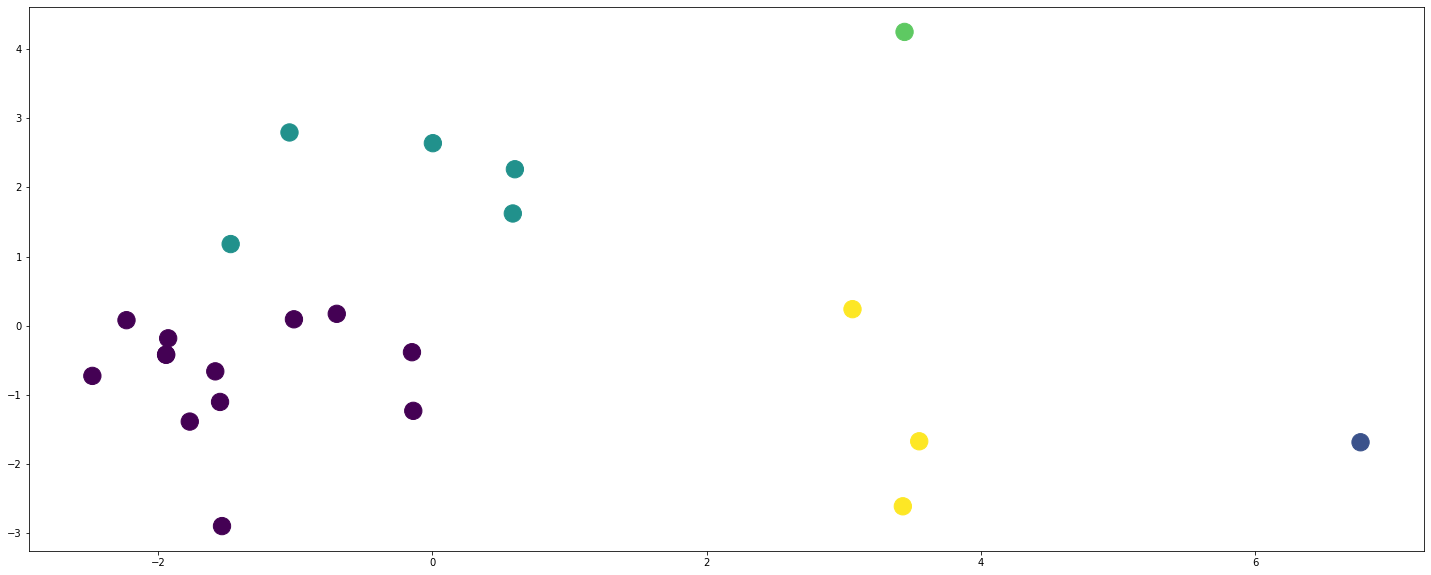

In [35]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

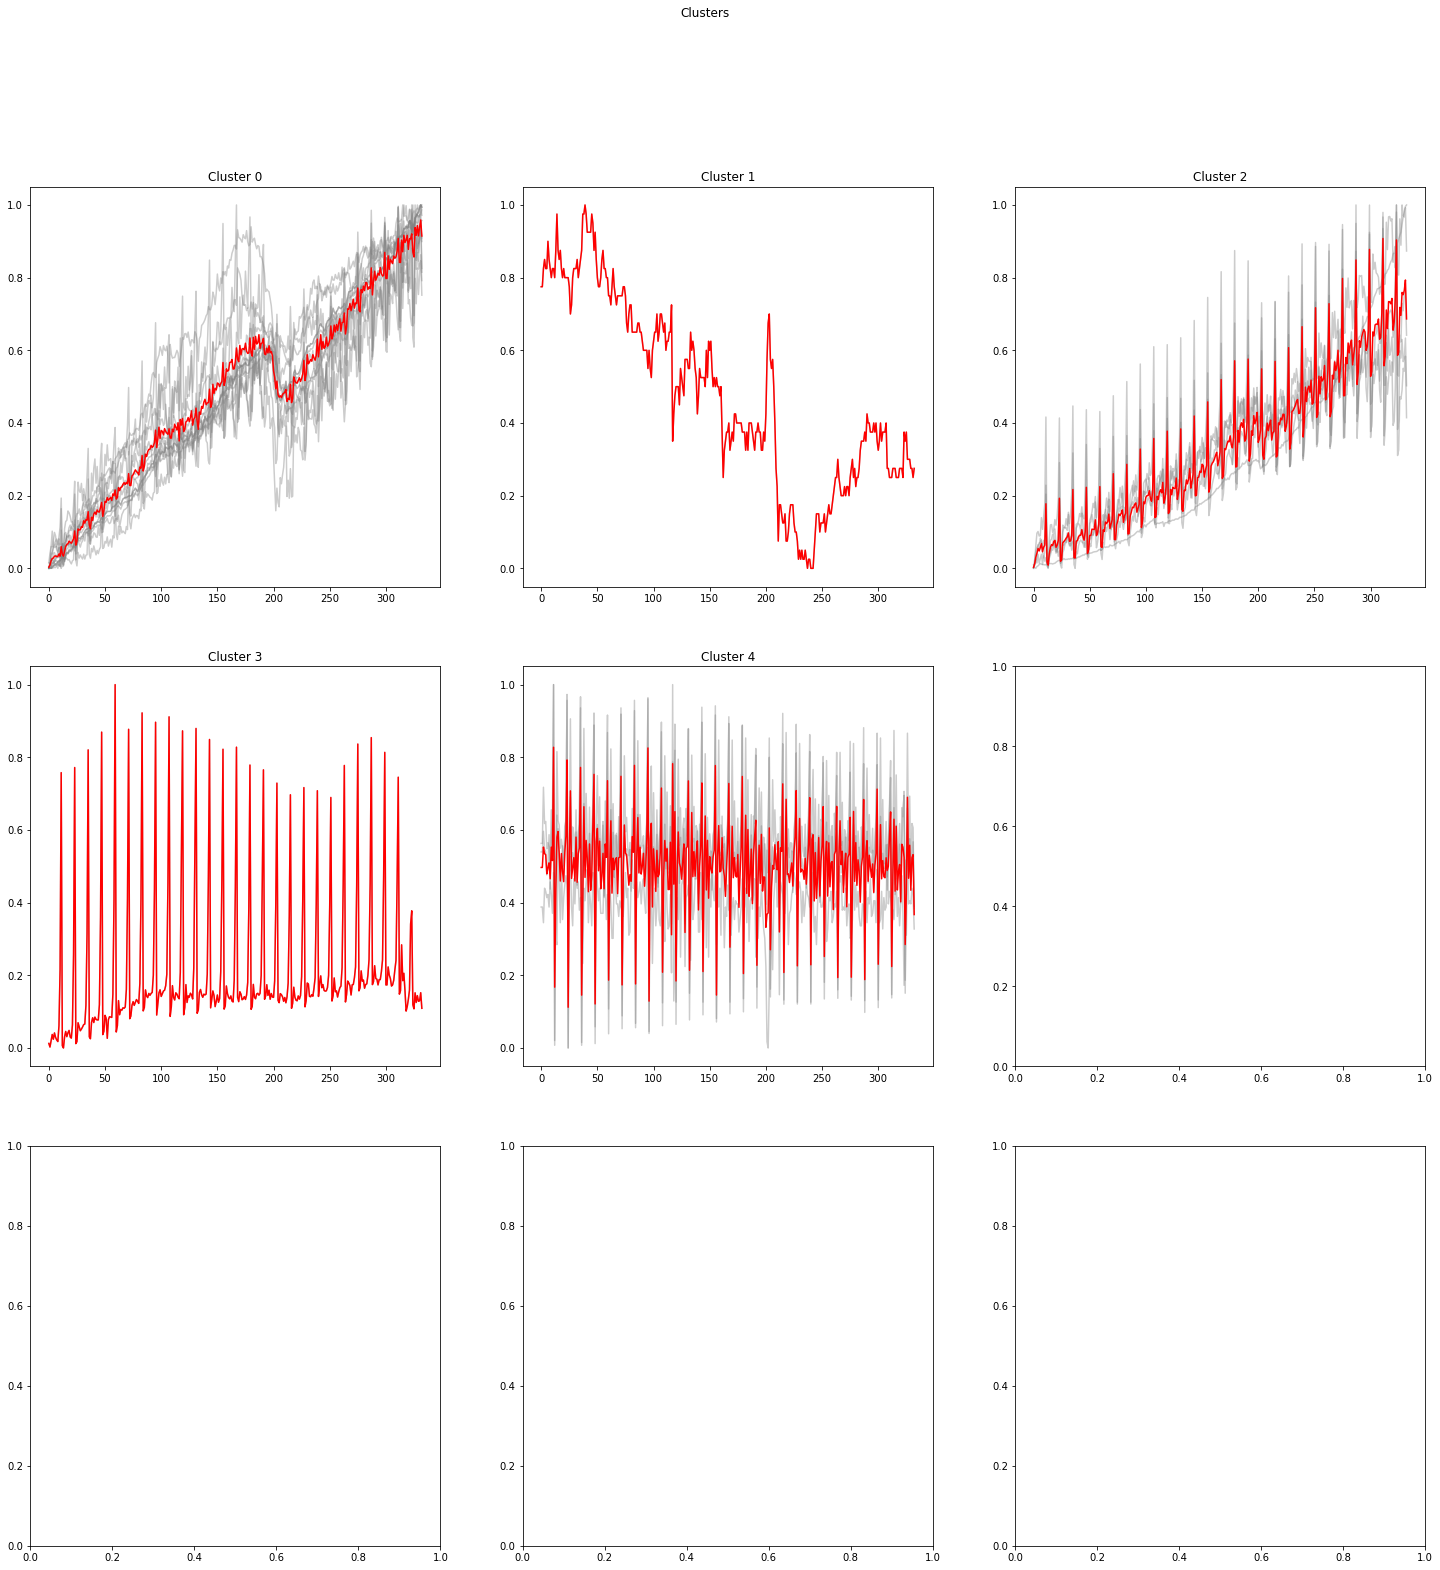

In [36]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

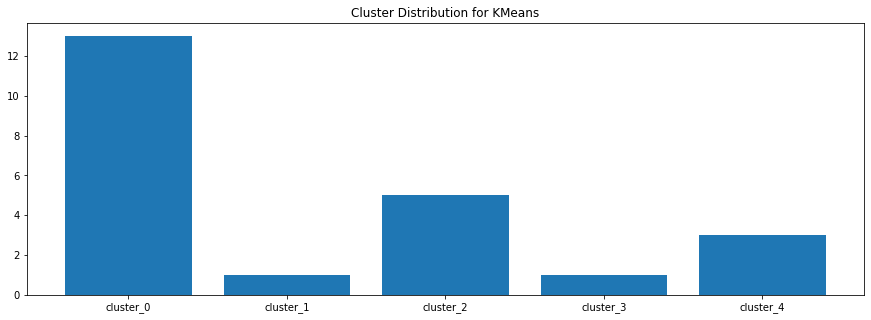

In [37]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [38]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
MRTSSM448USS,Cluster 0
RETAILIMSA,Cluster 0
MRTSSM44X72USS,Cluster 0
RETAILSMNSA,Cluster 0
MRTSSM44611USN,Cluster 0
MRTSSM444USS,Cluster 0
RETAILSMSA,Cluster 0
MRTSSM442USN,Cluster 0
MRTSSM4413USS,Cluster 0
